# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [11]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as TF
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
import os
import pandas as pd
from tqdm.notebook import tqdm
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [12]:
def imshow(img1, img2):
    img1 = TF.to_pil_image(img1, mode='L')
    img2 = TF.to_pil_image(img2, mode='L')
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.imshow(img1)
    plt.subplot(122)
    plt.imshow(img2)
    plt.show()    
    
def show_plot(train_loss, val_loss):
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.legend()
    plt.grid()
    plt.show()
    
def show_pred(test_results_0, test_results_1):
    plt.figure(figsize=(15, 5))
    plt.plot(test_results_0, label='pred distance of similar floorplans')
    plt.plot(test_results_1, label='pred distance of different floorplans')
    plt.legend()
    plt.grid()
    plt.savefig('./output/test.png')
    plt.show()

## Configuration Class
A simple class to manage configuration

In [13]:
class Config():
    train_file = './config/train_unit_ids.txt'
    val_file = './config/val_unit_ids.txt'
    test_file = './config/test_unit_ids.txt'
    
    data_dir = './data'
    checkpoint_dir = './checkpoint'
    
    batch_size = 16
    train_number_epochs = 100

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [14]:
class MadoriDataset(Dataset):
    
    def _prepare(self):
        if self.test:
            data_file = Config.test_file
        else:
            data_file = Config.train_file if self.train else Config.val_file
        with open(data_file, 'r') as f:
            lines = f.readlines()
        f.close()
        self.unit_paths = [os.path.join(Config.data_dir, line.strip()) for line in lines]
        
    def __init__(self, img_size=(256, 256), train=True, test=False):
        self.train = train
        self.test = test
        self.img_size = (256, 256)
        self._prepare()
        
    def __len__(self):
        return len(self.unit_paths)
    
    def _resize(self, img):
        w, h = img.size
        if w < h:
            a = 256.0 / h
            b = int(w * a)
            img = img.resize((b, 256), Image.BILINEAR)
        else:
            a = 256.0 / w
            b = int(h * a)
            img = img.resize((256, b), Image.BILINEAR)
        return img
    
    def _pad2(self, img):
        w, h = img.size
        img = TF.pad(img, (0,0,256-w,0), padding_mode='edge') if h == 256 else \
               TF.pad(img, (0,0,0,256-h), padding_mode='edge')
        return img
    
    def _pad(self, img):
        w, h = img.size
        return TF.pad(img, (0,0,256-w,0), fill=255) if h == 256 else \
               TF.pad(img, (0,0,0,256-h), fill=255)
    
    def _transform(self, img):
        return self._pad(self._resize(img))
    
    def _aug_img(self, image):
        if random.random() > 0.5:
            image = TF.rotate(image, random.choice([90, 180, 270]))
        if random.random() > 0.5:
            image = TF.hflip(image)
        if random.random() > 0.5:
            image = TF.vflip(image)
        return image
    
    def _select_img_path(self, unit_path, not_equal_to=None):
        img_path = os.path.join(unit_path, random.choice(os.listdir(unit_path)))
        if not_equal_to:
            while img_path == not_equal_to:
                img_path = os.path.join(unit_path, random.choice(os.listdir(unit_path)))
        return img_path
    
    def __getitem__(self, idx):
        
        unit_path1 = self.unit_paths[idx]
        
        img1_path = self._select_img_path(unit_path1)
        img1 = self._transform(Image.open(img1_path).convert('L'))
        
        label = random.randint(0, 1)
        if label:
            # choose different floorplan
            unit_path2 = unit_path1
            while unit_path2 == unit_path1:
                unit_path2 = random.choice(self.unit_paths)            
            img2 = self._transform(Image.open(self._select_img_path(unit_path2)).convert('L'))
        else:
            # choose similar floorplan by augmentation
            img2_path = self._select_img_path(unit_path1, not_equal_to=img1_path)
            img2 = self._transform(Image.open(img2_path).convert('L'))
            
        img1, img2 = TF.to_tensor(self._aug_img(img1)), TF.to_tensor(self._aug_img(img2))
        return img1, img2, torch.from_numpy(np.array([label],dtype=np.float32))

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

torch.Size([16, 1, 256, 256]) torch.Size([16, 1, 256, 256])
tensor([0.])


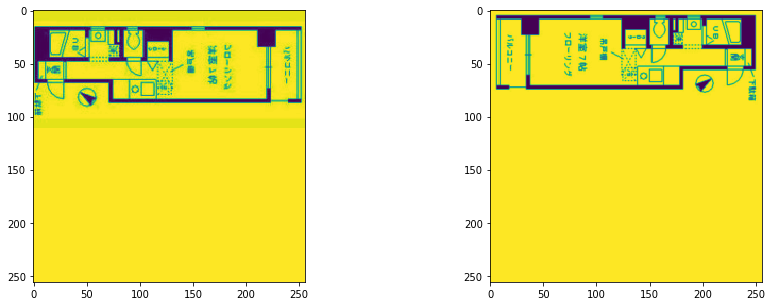

tensor([0.])


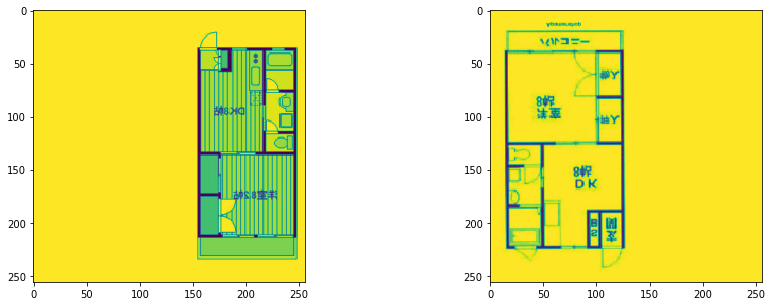

tensor([1.])


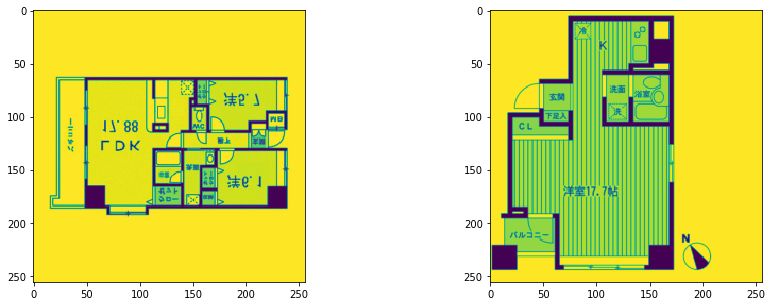

In [15]:
dset_loader = DataLoader(MadoriDataset(), 
                           batch_size=Config.batch_size, 
                           shuffle=True)

for i, batch in enumerate(dset_loader):
    img1, img2, label = batch
    print(img1.size(), img2.size())
    for k in range(3):
        print(label[k])
        imshow(img1[k], img2[k])
    break

## Neural Net Definition
We will use a standard convolutional neural network

In [16]:
class ResConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding=1, batch_norm=True):
        super(ResConvBlock, self).__init__()

        if batch_norm:
            bn = nn.BatchNorm2d

        self.conv1 = nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding))
        self.bn1 = bn(out_size)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding))
        self.bn2 = bn(out_size)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding))
        self.bn3 = bn(out_size)
        self.relu3 = nn.ReLU()

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        identity = x
        
        out = self.conv2(x)
        out = self.bn2(out)
        out = self.relu2(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        out += identity
        out = self.relu3(out)
        
        return out

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.resnet1 = ResConvBlock(1, 8)
        self.resnet2 = ResConvBlock(8, 8)
        
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(8*256*256, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 32))

    def forward_once(self, x):
        output = self.cnn1(x)
        
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=5.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - 
                                        euclidean_distance, min=0.0), 2))
        return loss_contrastive

## Training Time!

In [ ]:
train_dataloader = DataLoader(MadoriDataset(), 
                                shuffle=True,
                                batch_size=Config.batch_size)

val_dataloader = DataLoader(MadoriDataset(train=False), 
                                shuffle=False,
                                batch_size=Config.batch_size)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
net = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
train_loss_history, val_loss_history = [], []
lowest_epoch_train_loss = lowest_epoch_val_loss = float('inf')

In [ ]:
for epoch in tqdm(range(Config.train_number_epochs)):
    # training
    net.train()
    epoch_train_loss = 0
    for batch_no, data in enumerate(train_dataloader):
        img0, img1, label = data
        img0, img1, label = img0.to(device), img1.to(device) , label.to(device)
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        batch_train_loss = criterion(output1,output2,label)
        epoch_train_loss += batch_train_loss.item()
        batch_train_loss.backward()
        optimizer.step()
    epoch_train_loss /= (batch_no + 1)
    if epoch_train_loss < lowest_epoch_train_loss:
        lowest_epoch_train_loss = epoch_train_loss
        torch.save(net.state_dict(), f'{Config.checkpoint_dir}/best_train.pth')
    train_loss_history.append(epoch_train_loss)
    
    # validation
    net.eval()
    with torch.no_grad():
        epoch_val_loss = 0
        for batch_no, data in enumerate(val_dataloader):
            img0, img1, label = data
            img0, img1, label = img0.to(device), img1.to(device) , label.to(device)
            output1,output2 = net(img0,img1)
            batch_val_loss = criterion(output1,output2,label)
            epoch_val_loss += batch_val_loss.item()
        epoch_val_loss /= (batch_no + 1)
        if epoch_val_loss < lowest_epoch_val_loss:
            lowest_epoch_val_loss = epoch_val_loss
            torch.save(net.state_dict(), f'{Config.checkpoint_dir}/best_val.pth')
        val_loss_history.append(epoch_val_loss)
        
    print(f'Epoch {epoch} training loss {epoch_train_loss}, validation loss {epoch_val_loss}')

df = pd.DataFrame({'train_loss': train_loss_history, 'val_loss': val_loss_history})
df.to_csv('./train_val_loss.csv')

In [ ]:
df.iloc[:].plot(grid=True)
plt.show()

## Some simple testing

In [18]:
epoch_test = 0
net = SiameseNetwork().to(device)
net.load_state_dict(torch.load(f'{Config.checkpoint_dir}/best_val.pth'))
test_dataloader = DataLoader(MadoriDataset(Config.test_file, test=True), 
                             shuffle=False, 
                             batch_size=1)

In [19]:
net.eval()
test_results_0 = []
test_results_1 = []
with torch.no_grad():
    for batch_no, data in enumerate(test_dataloader):
        #if batch_no > 10: break
        img0, img1, label = data
        img0, img1, label = img0.to(device), img1.to(device) , label.to(device)
        output1,output2 = net(img0,img1)
        euclidean_distance = F.pairwise_distance(output1, output2)
        
        img0, img1 = img0.cpu(), img1.cpu()
        print(f'label: {label.item()}, pred distance: {euclidean_distance.item()}')
        if label.item() == 1.0:
            test_results_1 += [euclidean_distance.item()]
        else:
            test_results_0 += [euclidean_distance.item()]

label: 0.0, pred distance: 1.6964035034179688
label: 1.0, pred distance: 0.3629714548587799
label: 1.0, pred distance: 5.235568523406982
label: 0.0, pred distance: 0.3873508870601654
label: 1.0, pred distance: 6.133500576019287
label: 0.0, pred distance: 2.352618932723999
label: 1.0, pred distance: 6.173336982727051
label: 0.0, pred distance: 1.523813247680664
label: 0.0, pred distance: 0.9526062607765198
label: 1.0, pred distance: 0.7072898149490356
label: 1.0, pred distance: 1.6189687252044678
label: 0.0, pred distance: 0.3607480227947235
label: 1.0, pred distance: 1.4743248224258423
label: 0.0, pred distance: 0.8959039449691772
label: 1.0, pred distance: 2.9990122318267822
label: 0.0, pred distance: 0.20995694398880005
label: 0.0, pred distance: 1.3069359064102173
label: 1.0, pred distance: 3.5770022869110107
label: 0.0, pred distance: 0.8301845788955688
label: 1.0, pred distance: 7.3232421875
label: 0.0, pred distance: 0.8513354659080505
label: 0.0, pred distance: 0.781243741512298

label: 1.0, pred distance: 1.0566343069076538
label: 0.0, pred distance: 2.2781832218170166
label: 0.0, pred distance: 1.2286620140075684
label: 0.0, pred distance: 0.9842297434806824
label: 1.0, pred distance: 6.747298717498779
label: 0.0, pred distance: 1.0586121082305908
label: 1.0, pred distance: 7.230040073394775
label: 0.0, pred distance: 0.46704545617103577
label: 1.0, pred distance: 1.8312100172042847
label: 0.0, pred distance: 4.457468032836914
label: 0.0, pred distance: 1.1185095310211182
label: 1.0, pred distance: 5.069258213043213
label: 1.0, pred distance: 4.8285627365112305
label: 0.0, pred distance: 2.222499132156372
label: 0.0, pred distance: 1.2719571590423584
label: 1.0, pred distance: 2.621715545654297
label: 0.0, pred distance: 0.956317126750946
label: 0.0, pred distance: 0.5916858315467834
label: 1.0, pred distance: 6.48853874206543
label: 1.0, pred distance: 1.554715871810913
label: 1.0, pred distance: 3.951376438140869
label: 0.0, pred distance: 0.881339371204376

label: 0.0, pred distance: 1.5721688270568848
label: 1.0, pred distance: 5.394742488861084
label: 0.0, pred distance: 3.1736419200897217
label: 1.0, pred distance: 1.7930500507354736
label: 0.0, pred distance: 1.0544837713241577
label: 0.0, pred distance: 2.347510576248169
label: 1.0, pred distance: 2.33890962600708
label: 1.0, pred distance: 1.1192996501922607
label: 1.0, pred distance: 5.570117950439453
label: 1.0, pred distance: 3.140721321105957
label: 1.0, pred distance: 4.8687615394592285
label: 0.0, pred distance: 3.0512354373931885
label: 0.0, pred distance: 0.366877943277359
label: 1.0, pred distance: 0.7740814089775085
label: 1.0, pred distance: 0.8755945563316345
label: 0.0, pred distance: 1.571234941482544
label: 0.0, pred distance: 0.26149624586105347
label: 1.0, pred distance: 2.327214002609253
label: 0.0, pred distance: 2.666290283203125
label: 0.0, pred distance: 1.4596830606460571
label: 0.0, pred distance: 0.5230900645256042
label: 1.0, pred distance: 4.55982828140258

label: 1.0, pred distance: 0.371410071849823
label: 1.0, pred distance: 2.5400583744049072
label: 1.0, pred distance: 4.5932207107543945
label: 0.0, pred distance: 0.24660582840442657
label: 1.0, pred distance: 5.5266289710998535
label: 1.0, pred distance: 5.038572311401367
label: 1.0, pred distance: 4.101935863494873
label: 0.0, pred distance: 1.9125794172286987
label: 1.0, pred distance: 5.934207916259766
label: 0.0, pred distance: 1.2304315567016602
label: 1.0, pred distance: 3.2310266494750977
label: 1.0, pred distance: 5.867189884185791
label: 1.0, pred distance: 3.8746399879455566
label: 1.0, pred distance: 2.8728466033935547
label: 1.0, pred distance: 2.7282843589782715
label: 0.0, pred distance: 1.7815754413604736
label: 1.0, pred distance: 4.186313629150391
label: 0.0, pred distance: 0.9090905785560608
label: 1.0, pred distance: 2.828627347946167
label: 0.0, pred distance: 1.470906376838684
label: 1.0, pred distance: 6.263983726501465
label: 1.0, pred distance: 1.5798945426940

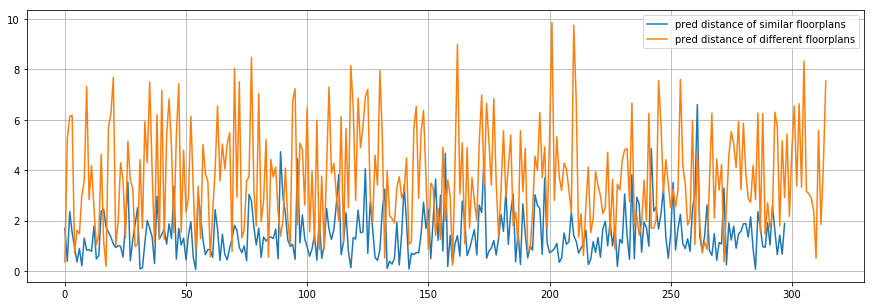

In [20]:
show_pred(test_results_0, test_results_1)

In [21]:
with open('./output/siamese/loss.txt') as f:
    lines = f.readlines()
f.close()

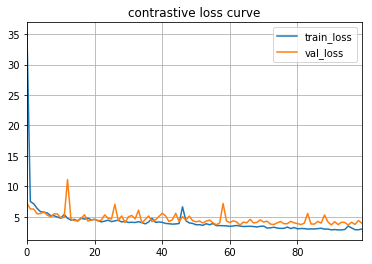

In [31]:
train_loss = []
val_loss = []
for line in lines:
    
    item1, item2 = line.split(',')
    train_loss += [float(item1.split()[-1])]
    val_loss += [float(item2.split()[-1])]
    
df = pd.DataFrame({'train_loss': train_loss[:], 'val_loss': val_loss[:]})
df.plot(grid=True, title='contrastive loss curve')

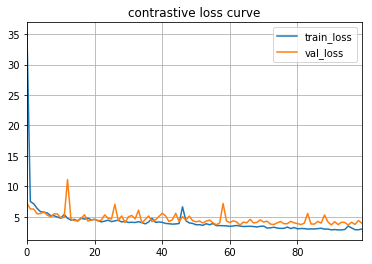

In [32]:
fig = df.plot(grid=True, title='contrastive loss curve').get_figure()

fig.savefig('./output/siamese/loss.png')